# Reiforcement Learning ep.1: Q-Learning

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/solved-notebooks/SOLVED-Lab-15.RL_QLearning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Goal:** *teach a Taxi to pick up and drop off passengers at the right locations with Reinforcement Learning*.

## Quick recap
Consider the scenario of teaching a dog new tricks. The dog doesn't understand our language, so we can't tell him what to do. Instead, we follow a different strategy. We emulate a situation (or a cue), and the dog tries to respond in many different ways. If the dog's response is the desired one, we reward them with snacks. Now guess what, the next time the dog is exposed to the same situation, the dog executes a similar action with even more enthusiasm in expectation of more food. That's like learning "what to do" from positive experiences. Similarly, dogs will tend to learn what not to do when face with negative experiences.

That's exactly how Reinforcement Learning works in a broader sense:

* Your dog is an "agent" that is exposed to the **environment**. The environment could in your house, with you.
* The situations they encounter are analogous to a **state**. An example of a state could be your dog standing and you use a specific word in a certain tone in your living room.
* Our agents react by performing an **action** to transition from one "state" to another "state," your dog goes from standing to sitting, for example.
* After the transition, they may receive a **reward** or **penalty** in return. You give them a treat! Or a "No" as a penalty.
* The **policy** is the strategy of choosing an action given a state in expectation of better outcomes.


Reinforcement Learning lies between the spectrum of Supervised Learning and Unsupervised Learning, and there's a few important things to note:

1. **Being greedy doesn't always work**  
There are things that are easy to do for instant gratification, and there's things that provide long term rewards. The goal is to not be greedy by looking for the quick immediate rewards, but instead to optimize for maximum rewards over the whole training.  
2. **Sequence matters in Reinforcement Learning**  
The reward agent does not just depend on the current state, but the entire history of states. Unlike supervised and unsupervised learning, time is important here.

### The process
In a way, Reinforcement Learning is the science of making optimal decisions using experiences. Breaking it down, the process of Reinforcement Learning involves these simple steps:

1. Observation of the environment
2. Deciding how to act using some strategy
3. Acting accordingly
4. Receiving a reward or penalty
5. Learning from the experiences and refining our strategy
6. Iterate until an optimal strategy is found


![alt](https://storage.googleapis.com/lds-media/documents/Reinforcement-Learning-Animation.gif)


## Self-driving cab

Let's design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

* Drop off the passenger to the right location.
* Save passenger's time by taking minimum time possible to drop off
* Take care of passenger's safety and traffic rules


There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions.

#### Rewards

Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly. Here a few points to consider:

* The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired
* The agent should be penalized if it tries to drop off a passenger in wrong locations
* The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible

#### State Space
In Reinforcement Learning, the agent encounters a state, and then takes action according to the state it's in.

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

![alt](https://storage.googleapis.com/lds-media/images/Reinforcement_Learning_Taxi_Env.width-1200.png)

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a $5x5$ grid, which gives us $25$ possible taxi locations. These $25$ locations are one part of our state space. Notice the current location state of our taxi is coordinate $(3, 1)$.

You'll also notice there are 4 locations that we can pick up and drop off a passenger: R, G, Y, B or $[(0,0), (0,4), (4,0), (4,3)]$ in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's $4$ destinations and five $(4 + 1)$ passenger locations.

So, our taxi environment has $5x5x5x4 = 500$ total possible states.

#### Action Space

The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger.

In other words, we have six possible actions:

1. South
2. North
3. East
4. West
5. Pickup
6. Dropoff

This is the action space: the set of all the actions that our agent can take in a given state.

You'll notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a $-1$ penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.


### Implementation

Fortunately, [OpenAI Gymnasium](https://gymnasium.farama.org) has this exact environment already built for us.

Gym provides different game environments which we can plug into our code and test an agent. The library takes care of API for providing all the information that our agent would require, like possible actions, score, and current state. We just need to focus just on the algorithm part for our agent.

We'll be using the Gym environment called [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/), which all of the details explained above were pulled from. The objectives, rewards, and actions are all the same.

First, we need to install `gymnasium`. Then, we can load the game environment and render what it looks like.

In [1]:
! pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython import display
from IPython.display import clear_output
from time import sleep
import random

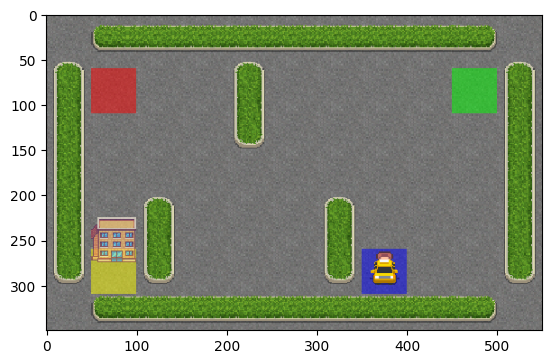

In [3]:
env = gym.make('Taxi-v3',render_mode = "rgb_array").env

env.reset()
img = env.render()
plt.imshow(img)

The core gym interface is `env`, which is the unified environment interface. The following are the `env` methods that would be quite helpful to us:

* `env.reset`: Resets the environment and returns a random initial state.
* `env.step(action)`: Step the environment by one timestep. Returns
  - **observation**: Observations of the environment
  - **reward**: If your action was beneficial or not
  - **done**: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
  - **truncated**: Whether the truncation condition outside the scope of the MDP is satisfied. Typically, this is a timelimit, but could also be used to indicate an agent physically going out of bounds
  - **info**: Additional info containing the probability that the state is taken and a mask of what actions will result in a change of state to speed up training
* `env.render`: Renders one frame of the environment (helpful in visualizing the environment)

*Note*: We are using the `.env` on the end of make to avoid training stopping at 200 iterations, which is the default for the new version of Gym.

Here's our restructured problem statement (from Gym docs):

> There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

Let's dive more into the environment.

In [4]:
print("Action Space: {}".format(env.action_space))
print("State Space: {}".format(env.observation_space))

Action Space: Discrete(6)
State Space: Discrete(500)


As verified by the prints, we have an Action Space of size $6$ and a State Space of size $500$. As you'll see, our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:

- 0 = south
- 1 = north
- 2 = east
- 3 = west
- 4 = pickup
- 5 = dropoff

Recall that the $500$ states correspond to a encoding of the taxi's location, the passenger's location, and the destination location.

Reinforcement Learning will learn a mapping of **states** to the optimal **action** to perform in that state by *exploration*, i.e. the agent explores the environment and takes actions based off rewards defined in the environment.

The optimal action for each state is the action that has the *highest cumulative long-term reward*.

When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a $states \times actions$ matrix.

Since every state is in this matrix, we can see the default reward values assigned to our illustration's state. The output is a dictionary with the structure `{action: [(probability, nextstate, reward, done)]}`.

In [5]:
current_state = env.env.s
print("Current state: {}".format(current_state))

Current state: 474


In [6]:
env.P[current_state]

{0: [(1.0, 474, -1, False)],
 1: [(1.0, 374, -1, False)],
 2: [(1.0, 494, -1, False)],
 3: [(1.0, 474, -1, False)],
 4: [(1.0, 478, -1, False)],
 5: [(1.0, 474, -10, False)]}

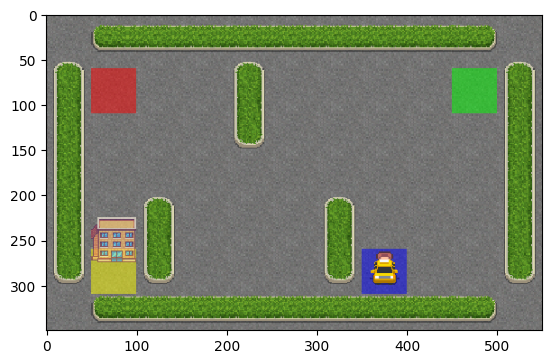

In [7]:
# to have close for comparison
plt.imshow(img)

A few things to note:

- The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
- In this env, `probability` is always 1.0.
- The `nextstate` is the state we would be in if we take the action at this index of the dict
- All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
- `done` is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode 

The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accumulating $-1$ penalties, which affects the long-term reward.

### Solving the environment without RL
Let's see what would happen if we try to brute-force our way to solving the problem without RL.

Since we have our `P` table for default rewards in each state, we can try to have our taxi navigate just using that.

We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is $20$. The `env.action_space.sample()` method automatically selects one random action from set of all possible actions.

Let's see what happens:

In [8]:
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False
maxepochs = 1000

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1

    if truncated:
      break 
    if epochs == maxepochs:
      break
    

print("Done: {}".format(done))
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Done: False
Timesteps taken: 1000
Penalties incurred: 323


In [3]:
# deprecated, very slow and messy
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        plt.imshow(frame['frame'])
        plt.title(f"Timestep: {i + 1}")
        plt.axis("off")
        plt.show()

        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        plt.pause(0.2)
        sleep(0.2)


# use this to visualise what is happening
def display_animation(frames):
  # turn off matplotlib plot in notebook
  plt.ioff()

  fps = 5   # Set frames per seconds
  dpi = 300  # Set dots per inch
  interval = 100  # Interval between frames (in ms)

  # Retrieve frames from experience buffer
  allframes = []
  for frame in frames:
      allframes.append(frame['frame'])

  # Fix frame size
  plt.figure(figsize=(allframes[0].shape[1] / dpi, allframes[0].shape[0] / dpi), dpi=dpi)
  patch = plt.imshow(allframes[0])
  plt.axis('off')

  # Generate animation
  def animate(i):
      patch.set_data(allframes[i])

  anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(allframes), interval=interval)

  video = anim.to_html5_video()
  html = display.HTML(video)
  return html

In [10]:
html = display_animation(frames)
display.display(html)

Not good. Our agent takes thousands of timesteps (if we let it) and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize. The agent has no memory of which action was best for each state, which is exactly what Reinforcement Learning will do for us.

### Enter Q-Learning

We are going to use a simple RL algorithm called Q-learning which will give our agent some memory.

Essentially, Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

In our Taxi environment, we have the reward table, `P`, that the agent will learn from. It does this by receiving a reward for taking an action in the current state, then updating a *Q-value* to remember if that action was beneficial. Each Q-value is mapped to a `(state, action)` combination.

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Higher Q-values imply better chances of getting greater rewards.

For example, if the taxi is faced with a state that includes a passenger at its current location, it is highly likely that the Q-value for `pickup` is higher when compared to other actions, like `dropoff` or `north`.

Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

$$Q(S,A) \leftarrow (1- \alpha)\, Q(S,A) + \alpha \big( R + \gamma \max_{a'} Q(S',a')\big)$$

where:
- $\alpha$ is the learning rate ($0 \le \alpha \le 1$) - Just like in supervised learning settings,  is the extent to which our Q-values are being updated in every iteration.
- $\gamma$  is the discount factor ($0 \le \gamma \le 1$) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

**Translation:**  
We are updating the Q-value of the agent's current state and action by first taking a weight ($1- \alpha$) of the old Q-value, then adding the learned value. The learned value is a combination of the reward for taking the current action in the current state, and the discounted maximum reward from the next state we will be in once we take the current action.

Basically, we are learning the proper action to take in the current state by looking at the reward for the current state/action combo, and the max rewards for the next state. This will eventually cause our taxi to consider the route with the best rewards strung together.

The Q-value of a state-action pair is the sum of the instant reward and the discounted future reward (of the resulting state). The way we store the Q-values for each state and action is through a **Q-table**.

The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training. Note that the Q-table has the same dimensions as the reward table, but it has a completely different purpose.

#### Algorithm

Breaking it down into steps, we get

1. Initialize the Q-table by all zeros

Repeat for each episode:
2. Initialise S

Repeat for each step of episode:
3. Choose A from S using policy derived from the Q table
4. Take action A, observe R, S'
5. Update Q table
6. S $\leftarrow$ S'


After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between *exploration* (choosing a random action) and *exploitation* (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called $ɛ$ to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. A lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

#### Implementation

First, we'll initialize the Q-table to a $500 \times 6$ matrix of zeros. We can then create the training algorithm that will update this Q-table as the agent explores the environment over thousands of episodes.

In [11]:
env = gym.make('Taxi-v3',render_mode = "rgb_array").env

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
Iter = 100

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, Iter+1):
    env.reset()
    state = env.env.s

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, truncated, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
        if truncated:
          break

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        
print("Training finished.\n")

Episode: 100
Training finished.



In [12]:
q_table[269]

array([-1.92125858, -1.9341781 , -1.94337031, -1.92805868, -2.82976   ,
       -5.01239065])

Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value.

In [ ]:
env.reset()

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1

    if truncated:
      print("Truncated!")
      break 

    

print("Done: {}".format(done))
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

In [ ]:
html = display_animation(frames)
display.display(html)

### SARSA

SARSA, which expands to State, Action, Reward, State, Action, is an on-policy value-based approach. As a form of value iteration, its value update rule is 
$$Q(S,A) \leftarrow (1- \alpha)\, Q(S,A) + \alpha \big( R + \gamma Q(S', A')\big)$$

#### Algorithm

Breaking it down into steps, we get

1. Initialize the Q-table by all zeros

Repeat for each episode:
2. Initialise S
3. Choose A from S using policy derived from Q table

Repeat for each step of episode:
4. Take action A, observe R, S'
5. Choose A' from S' using policy derived from Q table
5. Update Q table
6. S $\leftarrow$ S', A $\leftarrow$ A'


The Q-value update rule is what distinguishes SARSA from Q-learning. In SARSA we see that the time difference value is calculated using the current state-action combo and the next state-action combo. This means we need to know the next action our policy takes in order to perform an update step.  
This makes SARSA an on-policy algorithm as it is updated based on the current choices of our policy.


##### **1. Repeat the previous computations with SARSA. How do they compare with the ones with Q Learning?**
*Tip: it will be slower, so choose less iterations to avoid waiting >30 mins!*



In [4]:
env = gym.make('Taxi-v3',render_mode = "rgb_array").env

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1
Iter = 10000

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, Iter+1):
    env.reset()
    state = env.env.s

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, truncated, info = env.step(action) 
        
        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample() # Explore action space
        else:
            next_action = np.argmax(q_table[state]) # Exploit learned values

        old_value = q_table[state, action]
        next_value = q_table[next_state, next_action]
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_value)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
        if truncated:
          break

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        
print("Training finished.\n")

Episode: 10000
Training finished.



In [ ]:
env.reset()

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1

    if truncated:
      print("Truncated!")
      break 

    

print("Done: {}".format(done))
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

In [ ]:
# finisce la ram

html = display_animation(frames)
display.display(html)

## SARSA vs Q-Learning

|| SARSA | Q-Learning |
|---|---|---|
|| On-policy | Off-policy
Choosing A' | ɛ-greedy policy | ɛ-greedy policy
Updating Q | ɛ-greedy policy | greedy policy (ɛ = 0)
Convergence speed | Usually slower | Usually faster
Action choice | More cautious | Optimistic
When preferred | When we care about the agent's performance during learning | When we don't [...], we just want to learn the optimal policy


### In very very simple terms

The main difference between Q-learning and SARSA lies in how they learn and update their knowledge.

Q-learning is like a smart student who learns from mistakes. It explores the environment, tries different actions, and learns from the consequences. It keeps track of the maximum expected reward for each state-action pair in the Q-table. Q-learning uses the maximum reward it expects to get in the next state to update its knowledge. It's like saying, "Hey, what's the best action I can take from this state to get the highest reward in the next state?"

On the other hand, SARSA is like a cautious student who learns while following a specific strategy. It explores the environment, tries different actions, and updates its knowledge based on the action it actually takes and the reward it receives. SARSA looks at the current action it took, observes the reward it got, and then decides on the next action based on its policy. It's like saying, "Okay, I did this action, I got this reward, and I think I should take this next action based on my current strategy."

So, in summary:

Q-learning learns from the maximum expected rewards in the next state and can be more focused on finding the optimal policy.
SARSA learns from the actual rewards it receives and takes into account its current strategy or policy.
Because of this difference, Q-learning can sometimes learn faster but may explore suboptimal actions before finding the best policy. SARSA, on the other hand, is more cautious and may take longer to converge but can be more careful in its decision-making.

